In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

import pandas as pd
import os
import PIL.Image as Image
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from plot_utils.MNIST_plot_utils import plot_ten_images, tile_raster_images
from plot_utils.ts_plot_utils import plot_ts, plot_ts_recon

In [2]:
#gpu_devices = tf.config.experimental.list_physical_devices("GPU")
#for device in gpu_devices:
#    tf.config.experimental.set_memory_growth(device, True)

In [3]:
def corrupt(X, eps, p_corr):
    X_all_corr = np.random.random(size=X.shape)
    #X_all_corr = X + eps * np.random.randn(X.shape[0], X.shape[1])
    #X_all_corr = np.clip(X_all_corr, 0, 1)
    mask = np.random.choice([0, 1], size=X.shape, p=[1-p_corr, p_corr]) != 0
    X_corr = X.copy()
    X_corr[mask] = X_all_corr[mask]
    return X_corr

def subsequences(ts, window):
    shape = (ts.size - window + 1, window)
    strides = ts.strides * 2
    return np.lib.stride_tricks.as_strided(ts, shape=shape, strides=strides)

In [95]:
def prox_l1(lam, x):
    return (x > lam) * (x - lam) + (x < -lam) * (x + lam)

def prox_l21(lam, x):
    e = np.linalg.norm(x, axis=0, keepdims=False)
    for i in range(len(e)):
        if e[i] > lam:
            x[:,i] = x[:,i] - lam*e[i]
        else:
            x[:,i] = np.zeros(len(x[:,i]))
    return x
    

def get_Dense_encoder(input_size, dense_units):
    encoder = tf.keras.Sequential()
    #encoder = tf.keras.Sequential([
    #    layers.Input(shape=(input_size)),
    #    layers.Dense(units=dense_units[0], activation='relu'),
    #    layers.Dense(units=dense_units[1], activation='relu'),    
    #], name='Encoder')
    encoder.add(layers.Input(shape=(input_size)))
    for i in range(len(dense_units)):
        encoder.add(layers.Dense(units=dense_units[i], activation='relu'))
    return encoder

def get_Dense_decoder(input_size, dense_units):
    decoder = tf.keras.Sequential()
    #decoder = tf.keras.Sequential([
    #    layers.Input(shape=(dense_units[1])),
    #    layers.Dense(units=dense_units[0], activation='relu'),
    #    layers.Dense(units=input_size, activation='sigmoid'),
    #], name='Decoder')
    decoder.add(layers.Input(shape=(dense_units[-1])))
    for i in reversed(range(len(dense_units)-1)):
        decoder.add(layers.Dense(units=dense_units[i], activation='relu'))
    decoder.add(layers.Dense(units=input_size, activation='sigmoid'))
    return decoder

def get_LSTM_encoder(timesteps, features, LSTM_units, LSTM_dropout):
    encoder = tf.keras.Sequential()
    if len(LSTM_units) > 0:
        encoder.add(layers.LSTM(units=LSTM_units[0], dropout=LSTM_dropout, return_sequences=True, input_shape=(timesteps, features)))
        for i in range(len(LSTM_units)-2):
            encoder.add(layers.LSTM(units=LSTM_units[i+1], dropout=LSTM_dropout, return_sequences=True))
        encoder.add(layers.LSTM(units=LSTM_units[-1], dropout=LSTM_dropout, return_sequences=False))
    else:
        encoder.add(layers.LSTM(units=LSTM_units[0], dropout=LSTM_dropout, return_sequences=False, input_shape=(timesteps, features)))            
    #encoder = tf.keras.Sequential([
    #    layers.LSTM(units=LSTM_units[0], dropout=LSTM_dropout, return_sequences=True, input_shape=(timesteps, features)),
    #    layers.LSTM(units=LSTM_units[1], dropout=LSTM_dropout, return_sequences=False),
    #], name='Encoder')
    return encoder

def get_LSTM_decoder(timesteps, features, LSTM_units, LSTM_dropout):
    decoder = tf.keras.Sequential()
    decoder.add(layers.RepeatVector(timesteps))
    for i in reversed(range(len(LSTM_units))):
        decoder.add(layers.LSTM(units=LSTM_units[i], dropout=LSTM_dropout, return_sequences=True))
    decoder.add(layers.TimeDistributed(layer=layers.Dense(units=features, activation='sigmoid')))
    
    #decoder = tf.keras.Sequential([
    #    layers.RepeatVector(timesteps),
    #    layers.LSTM(units=LSTM_units[1], dropout=LSTM_dropout, return_sequences=True),
    #    layers.LSTM(units=LSTM_units[0], dropout=LSTM_dropout, return_sequences=True),
    #    layers.TimeDistributed(layer=layers.Dense(units=features)),
    #], name='Decoder')
    return decoder

In [5]:
### Deep Dense Autoencoder Model
class DAE_Dense(Model):
    def __init__(self, input_size, dense_units):
        super(DAE_Dense, self).__init__()
        self.encoder = get_Dense_encoder(input_size, dense_units)
        self.decoder = get_Dense_decoder(input_size, dense_units)
        
    def call(self, x, training=False):
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded

    def encode(self, x, training=False):
        encoded = self.encoder(x, training=training)
        return encoded
    
    def decode(self, x, training=False):
        decoded = self.decoder(x, training=training)
        return decoded
    
    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Reconstruct input
            x_encoded = self.encode(x, training=True)
            x_recon = self.decode(x_encoded, training=True)
            # Calculate loss
            loss = self.compiled_loss(x, x_recon)
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(x, x_recon)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


### Deep LSTM Autoencoder Model
class DAE_LSTM(Model):
    def __init__(self, timesteps, features, LSTM_units, LSTM_dropout):
        super(DAE_LSTM, self).__init__()
        self.encoder = get_LSTM_encoder(timesteps, features, LSTM_units, LSTM_dropout)
        self.decoder = get_LSTM_decoder(timesteps, features, LSTM_units, LSTM_dropout)
        
    def call(self, x, training=False):
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded

    def encode(self, x, training=False):
        encoded = self.encoder(x, training=training)
        return encoded
    
    def decode(self, x, training=False):
        decoded = self.decoder(x, training=training)
        return decoded
    
    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Reconstruct input
            x_encoded = self.encode(x, training=True)
            x_recon = self.decode(x_encoded, training=True)
            # Calculate loss
            loss = self.compiled_loss(x, x_recon)
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(x, x_recon)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [6]:
### Robust Autoencoder Model
class RobustAutoencoder:
    def __init__(self, AE_type: str, prox_type: str, input_size=784, dense_units=[200, 10], lr=3e-4, timesteps=24, features=1, LSTM_units=[64, 32], LSTM_dropout=0.0):
        super(RobustAutoencoder, self).__init__()
        assert AE_type=='Dense' or AE_type=='LSTM', 'AE_type has to be either Dense or LSTM'
        self.AE_type = AE_type
        
        assert prox_type=='l1' or prox_type=='l21', 'prox_type has to be either l1 or l21'
        self.prox_type = prox_type
        
        if self.AE_type=='Dense':
            self.AE = DAE_Dense(input_size, dense_units)
            self.AE.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss='mse',
                metrics=['mse']
            )
            #self.AE.build(input_shape=(input_size))
            #self.AE.summary()
            
        elif self.AE_type=='LSTM':
            self.AE = DAE_LSTM(timesteps, features, LSTM_units, LSTM_dropout)
            self.AE.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss='mse',
                metrics=['mse']
            )
            #self.AE.build(input_shape=(timesteps, features))
            #self.AE.summary()
        
        if self.prox_type=='l1':
            self.prox_fn = prox_l1
        elif self.prox_type=='l21':
            self.prox_fn = prox_l21
            
    def train_and_fit(self, X, train_iter: int, AE_train_iter: int, batch_size: int, eps: float, lam: float):
        if self.AE_type == 'Dense':
            self.default_shape = (X.shape[0], X.shape[1])
            self.utils_shape = (X.shape[0], X.shape[1])
        elif self.AE_type == 'LSTM':
            self.default_shape = (X.shape[0], X.shape[1], 1)
            self.utils_shape = (X.shape[0], X.shape[1])
        
        X = X.reshape(self.default_shape)
        self.L = np.zeros(self.default_shape)
        self.S = np.zeros(self.default_shape)
        self.LD = np.zeros(self.default_shape)
        self.LS = X
        
        for i in range(train_iter):
            print(f'RAE training iteration: {i+1}')
            self.LD = X - self.S
            # Now fit the autoencoder for some iters
            self.AE.fit(x=self.LD, batch_size=batch_size, epochs=AE_train_iter)
            self.LD = self.AE(self.LD).numpy()
            self.S = X - self.LD
            
            self.S = self.S.reshape(self.utils_shape)
            self.S = self.prox_fn(lam=lam, x=self.S.T).T
            self.S = self.S.reshape(self.default_shape)
            
            c1 = tf.linalg.norm(X - self.LD - self.S) / tf.linalg.norm(X)
            c2 = tf.linalg.norm(self.LS - self.LD - self.S) / tf.linalg.norm(X)
            if c1 < eps or c2 < eps:
                print(f'Early Convergence at iter {i+1}')
                break
            self.LS = self.LD + self.S
        return self.LD, self.S
    
    def get_reconstruction(self, X):
        return self.AE(X)
    
    def transform(self, X):
        L = X - self.S
        return self.AE.encode(L)

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0], 784))
x_test = x_test.reshape((x_test.shape[0], 784))
    
x_train_corr = corrupt(x_train, eps=1., p_corr=0.25)

print(f'Train data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

digit = 4
x_train_digit = x_train[y_train==digit]
np.random.shuffle(x_train_digit)
x_train_others = x_train[y_train!=digit]
np.random.shuffle(x_train_others)

anomaly_perc = 0.05

anomalies = np.random.choice(x_train_digit.shape[0], size=int(x_train_digit.shape[0]*anomaly_perc))
x_train_anomaly = x_train_digit.copy()
x_train_anomaly[anomalies] = x_train_others[:anomalies.shape[0]]
print(f'Total number of {digit}s in the anomaly data: {x_train_anomaly.shape[0]}, correct data: '
      f'{x_train_anomaly.shape[0]-anomalies.shape[0]}, anomalies: {anomalies.shape[0]}')



Train data shape: (60000, 784)
Test data shape: (10000, 784)
Total number of 4s in the anomaly data: 5842, correct data: 5550, anomalies: 292


In [8]:
RAEl1Dense = RobustAutoencoder(AE_type='Dense', prox_type='l1', input_size=x_train_corr.shape[1], dense_units=[200, 10], lr=3e-4)

In [9]:
LD_l1_MNIST, S_l1_MNIST = RAEl1Dense.train_and_fit(X=x_train_corr, train_iter=20, AE_train_iter=50, batch_size=128, eps=1e-8, lam=10.0)

RAE training iteration: 1
Epoch 1/50
469/469 [==============================] - 4s 3ms/step - loss: 0.0994 - mse: 0.0994
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0846 - mse: 0.0846
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0827 - mse: 0.0827
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0817 - mse: 0.0817
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0806 - mse: 0.0806
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0798 - mse: 0.0798
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0792 - mse: 0.0792
Epoch 8/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0788 - mse: 0.0788
Epoch 9/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0785 - mse: 0.0785
Epoch 10/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0782 - mse: 0.0782
Epoch 11/50
469/469 [==

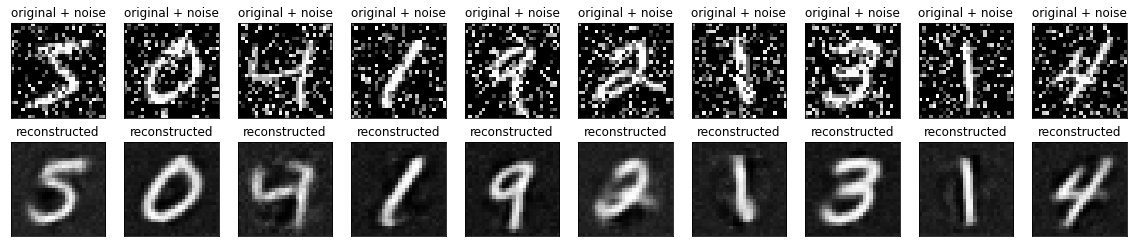

In [10]:
x_train_corr = x_train_corr.reshape((x_train_corr.shape[0], 28, 28, 1))
LD_l1_MNIST = LD_l1_MNIST.reshape((LD_l1_MNIST.shape[0], 28, 28, 1))
plot_ten_images(x_train_corr, LD_l1_MNIST)

In [20]:
RAEl21Dense = RobustAutoencoder(AE_type='Dense', prox_type='l21', input_size=x_train_anomaly.shape[1], dense_units=[200, 10], lr=0.005)

In [21]:
LD_l21_MNIST, S_l21_MNIST = RAEl21Dense.train_and_fit(X=x_train_anomaly, train_iter=20, AE_train_iter=50, batch_size=128, eps=1e-8, lam=0.05)

RAE training iteration: 1
Epoch 1/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0682 - mse: 0.0682
Epoch 2/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0441 - mse: 0.0441
Epoch 3/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0329 - mse: 0.0329
Epoch 4/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0290 - mse: 0.0290
Epoch 5/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0274 - mse: 0.0274
Epoch 6/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0262 - mse: 0.0262
Epoch 7/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0251 - mse: 0.0251
Epoch 8/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0234 - mse: 0.0234
Epoch 9/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0222 - mse: 0.0222
Epoch 10/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0214 - mse: 0.0214
Epoch 11/50
46/46 [========================

In [22]:
inputsize = (28,28)
Image.fromarray(tile_raster_images(X=S_l21_MNIST, img_shape=inputsize, tile_shape=(10, 10),tile_spacing=(1, 1))).save(r"l21S_MNIST.png")
Image.fromarray(tile_raster_images(X=RAEl21Dense.get_reconstruction(x_train_anomaly).numpy(), img_shape=inputsize, tile_shape=(10, 10),tile_spacing=(1, 1))).save(r"l21R_MNIST.png")
Image.fromarray(tile_raster_images(X=LD_l21_MNIST, img_shape=inputsize, tile_shape=(10, 10),tile_spacing=(1, 1))).save(r"l21L_MNIST.png")

In [23]:
print(S_l21_MNIST)

[[-2.3251371 -2.3251371 -2.3251371 ... -2.3251371 -2.3251371 -2.3251371]
 [-2.2942085 -2.2942085 -2.2942085 ... -2.2942085 -2.2942085 -2.2942085]
 [-2.2975776 -2.2975776 -2.2975776 ... -2.2975776 -2.2975776 -2.2975776]
 ...
 [-2.3115792 -2.3115792 -2.3115792 ... -2.3115792 -2.3115792 -2.3115792]
 [-2.3015032 -2.3015032 -2.3015032 ... -2.3015032 -2.3015032 -2.3015032]
 [-2.3412652 -2.3412652 -2.3412652 ... -2.3412652 -2.3412652 -2.3412652]]


In [24]:
#detected_anomalies = (np.sum((abs(S)>0.).astype(int), axis=1)>0.).astype(int)
detected_anomalies_MNIST = (np.linalg.norm(S_l21_MNIST, axis=1) > 0.).astype(int)
print(f'Detected_anomalies: {np.sum(detected_anomalies_MNIST)}')

true_anomalies_MNIST = np.zeros(x_train_digit.shape[0]).astype(int)
true_anomalies_MNIST[anomalies] = 1
np.sort(true_anomalies_MNIST)
accuracy_MNIST = accuracy_score(y_pred=detected_anomalies_MNIST, y_true=true_anomalies_MNIST)
precision_MNIST = precision_score(y_pred=detected_anomalies_MNIST, y_true=true_anomalies_MNIST)
recall_MNIST = recall_score(y_pred=detected_anomalies_MNIST, y_true=true_anomalies_MNIST)
f1_MNIST = f1_score(y_pred=detected_anomalies_MNIST, y_true=true_anomalies_MNIST)

print(f'Accuracy: {accuracy_MNIST}, precision: {precision_MNIST}, recall: {recall_MNIST}, F1 score: {f1_MNIST}')



Detected_anomalies: 5842
[0 0 0 ... 0 0 0]
Accuracy: 0.04946935980828483, precision: 0.04946935980828483, recall: 1.0, F1 score: 0.09427499592236176


In [83]:
df = pd.read_csv(os.path.join('data', 'realKnownCause', 'machine_temperature_system_failure.csv'), delimiter=',', decimal='.')
df.drop_duplicates(subset='timestamp', keep='first', inplace=True)
ts_timestamps = df.iloc[:,0].values[33:-186]
ts_values = np.array(df.iloc[:,1].values[33:-186])

#ts_values_daily = ts_values.copy().reshape((int(ts_values.shape[0]/(12*24)), 12*24, 1))

timesteps = 144
ts_data = subsequences(ts_values, timesteps)

scaler = MinMaxScaler()
ts_data_scaled = scaler.fit_transform(X=ts_data)

ts_train_dense = ts_data_scaled.copy()
np.random.shuffle(ts_train_dense)
ts_train_LSTM = ts_data_scaled.reshape((ts_data_scaled.shape[0], timesteps, 1))
np.random.shuffle(ts_train_LSTM)

In [84]:
RAEl21Dense_ts = RobustAutoencoder(AE_type='Dense', prox_type='l21', input_size=ts_train_dense.shape[1], dense_units=[60, 20], lr=0.005)

In [88]:
LD_l21_dense, S_l21_dense = RAEl21Dense_ts.train_and_fit(X=ts_train_dense, train_iter=20, AE_train_iter=50, batch_size=256, eps=1e-8, lam=0.5)

RAE training iteration: 1
Epoch 1/50
88/88 [==============================] - 0s 4ms/step - loss: 2.6061e-04 - mse: 2.6061e-04
Epoch 2/50
88/88 [==============================] - 0s 3ms/step - loss: 2.6161e-04 - mse: 2.6161e-04
Epoch 3/50
88/88 [==============================] - 0s 3ms/step - loss: 2.6002e-04 - mse: 2.6002e-04
Epoch 4/50
88/88 [==============================] - 0s 3ms/step - loss: 2.6206e-04 - mse: 2.6206e-04
Epoch 5/50
88/88 [==============================] - 0s 4ms/step - loss: 2.6458e-04 - mse: 2.6458e-04
Epoch 6/50
88/88 [==============================] - 0s 3ms/step - loss: 2.5582e-04 - mse: 2.5582e-04
Epoch 7/50
88/88 [==============================] - 0s 3ms/step - loss: 2.5901e-04 - mse: 2.5901e-04
Epoch 8/50
88/88 [==============================] - 0s 3ms/step - loss: 2.6261e-04 - mse: 2.6261e-04
Epoch 9/50
88/88 [==============================] - 0s 3ms/step - loss: 2.5827e-04 - mse: 2.5827e-04
Epoch 10/50
88/88 [==============================] - 0s 3ms/step 

[0 0 0 ... 0 0 0]
Detected anomalies: 428


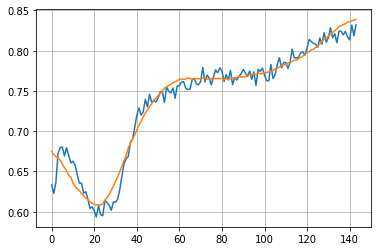

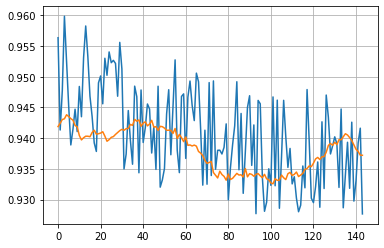

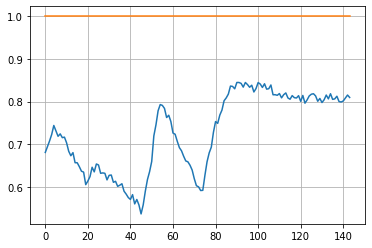

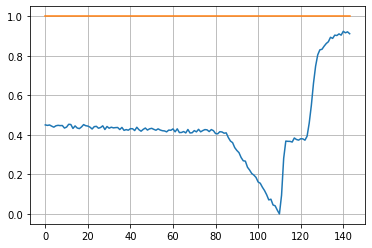

In [89]:
detected_anomalies_dense = (np.linalg.norm(S_l21_dense, axis=1) > 0.).astype(int)
print(detected_anomalies_dense)
print(f'Detected anomalies: {np.sum(detected_anomalies_dense)}')

#plot_ts_recon(ts_train_dense[0], RAEl21Dense_ts.get_reconstruction(ts_train_dense[0].reshape((1,-1))).numpy().reshape((-1)))
plot_ts_recon(ts_train_dense[0], LD_l21_dense[0])
plot_ts_recon(ts_train_dense[1000], LD_l21_dense[1000])
anomalies = np.argwhere(detected_anomalies_dense)
np.random.shuffle(anomalies)
plot_ts_recon(ts_train_dense[anomalies[0][0]], LD_l21_dense[anomalies[0][0]])
plot_ts_recon(ts_train_dense[anomalies[1][0]], LD_l21_dense[anomalies[1][0]])


In [96]:
RAEl21LSTM = RobustAutoencoder(AE_type='LSTM', prox_type='l21', timesteps=timesteps, features=1, lr=3e-4, LSTM_dropout=0.0, LSTM_units=[32, 16])

In [97]:
LD_l21_LSTM, S_l21_LSTM = RAEl21LSTM.train_and_fit(X=ts_train_LSTM, AE_train_iter=25, train_iter=10, lam=0.05, batch_size=256, eps=1e-8)

RAE training iteration: 1
Epoch 1/25
88/88 [==============================] - 7s 35ms/step - loss: 0.0399 - mse: 0.0399
Epoch 2/25
88/88 [==============================] - 3s 33ms/step - loss: 0.0140 - mse: 0.0140
Epoch 3/25
88/88 [==============================] - 3s 33ms/step - loss: 0.0074 - mse: 0.0074
Epoch 4/25
88/88 [==============================] - 3s 33ms/step - loss: 0.0055 - mse: 0.0055
Epoch 5/25
88/88 [==============================] - 3s 33ms/step - loss: 0.0048 - mse: 0.0048
Epoch 6/25
88/88 [==============================] - 3s 32ms/step - loss: 0.0044 - mse: 0.0044
Epoch 7/25
88/88 [==============================] - 3s 33ms/step - loss: 0.0041 - mse: 0.0041
Epoch 8/25
88/88 [==============================] - 3s 33ms/step - loss: 0.0039 - mse: 0.0039
Epoch 9/25
88/88 [==============================] - 3s 33ms/step - loss: 0.0037 - mse: 0.0037
Epoch 10/25
88/88 [==============================] - 3s 33ms/step - loss: 0.0036 - mse: 0.0036
Epoch 11/25
88/88 [==============

[1 1 1 ... 1 1 1]
Detected anomalies: 22321


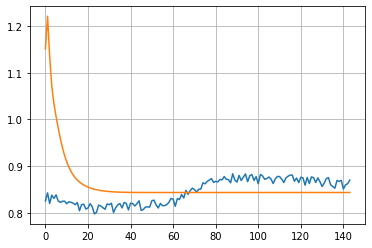

In [ ]:
from pyexpat import features
from time import time


shrinked_shape = (ts_train_LSTM.shape[0], ts_train_LSTM.shape[1])

detected_anomalies_LSTM = (np.linalg.norm(S_l21_LSTM.reshape(shrinked_shape), axis=1) > 0.).astype(int)
print(detected_anomalies_LSTM)
print(f'Detected anomalies: {np.sum(detected_anomalies_LSTM)}')

shrinked_shape = (ts_train_LSTM.shape[0], ts_train_LSTM.shape[1])
plot_ts_recon(ts_train_LSTM[0].reshape(timesteps), RAEl21LSTM.get_reconstruction(ts_train_LSTM[0].reshape((1,timesteps,1))).numpy().reshape((timesteps)))